In [1]:
# %pip install pandas numpy uvicorn fastapi pydantic cuda-toolkit==12.8 nvidia-cudnn-cu12==9.7.0.66 tf-nightly keras-nlp

In [2]:
from IPython.display import display, Markdown

from pandas import DataFrame, Series
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# TensorFlow et Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TextVectorization
import keras_nlp

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

2025-12-12 18:35:38.113112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765560938.130172  735747 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765560938.135557  735747 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765560938.148989  735747 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765560938.149008  735747 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765560938.149010  735747 computation_placer.cc:177] computation placer alr


TensorFlow version: 2.19.1
Keras version: 3.12.0
KerasNLP version: 0.24.0
⚠️  Aucun GPU détecté - Utilisation du CPU


2025-12-12 18:35:39.624004: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
original_df: DataFrame = pd.read_parquet('https://huggingface.co/api/datasets/textdetox/multilingual_toxicity_dataset/parquet/default/fr/0.parquet')

In [4]:
df = original_df.sample(frac=1)
df.head(5).reset_index(drop=True)

,text,toxic
0,n hesitez pas a utiliser le bouton Prévisualis...,0
1,Je vais te les faire bouffer en salade avec ta...,1
2,C'est vrai que les parisiennes ont les têtes d...,1
3,C’est elle qui a conduit à la situation « post...,0
4,"En fait, ils ont repris les codes de com du FN...",0


# EDA et traitement des données

In [5]:
# Recherche d'éléments manquants
df_notna_count = len(df)
df.dropna(inplace=True)
print(f"{len(df)}/{df_notna_count} messages restants après retrait d'éventuels manque dans les données ou les labels")

5000/5000 messages restants après retrait d'éventuels manque dans les données ou les labels


In [6]:
from tensorflow import Tensor


def custom_standardisation(t: Tensor) -> Tensor:
    # https://github.com/google/re2/wiki/Syntax
    # Remplacement manuel des lettres accentuées
    t = tf.strings.regex_replace(t, "[éèêë]", "e")
    t = tf.strings.regex_replace(t, "[ÉÈÊË]", "E")
    t = tf.strings.regex_replace(t, "[àâä]", "a")
    t = tf.strings.regex_replace(t, "[ÀÂÄ]", "A")
    t = tf.strings.regex_replace(t, "[îï]", "i")
    t = tf.strings.regex_replace(t, "[ÎÏ]", "I")
    t = tf.strings.regex_replace(t, "[ôö]", "o")
    t = tf.strings.regex_replace(t, "[ÔÖ]", "O")
    t = tf.strings.regex_replace(t, "[ùûü]", "u")
    t = tf.strings.regex_replace(t, "[ÙÛÜ]", "U")
    t = tf.strings.regex_replace(t, "ç", "c")
    t = tf.strings.regex_replace(t, "Ç", "C")
    t = tf.strings.regex_replace(t, "ÿ", "y")
    t = tf.strings.regex_replace(t, "Ÿ", "Y")

    t = tf.strings.lower(t)
    t = tf.strings.regex_replace(t, r"[a-z]+://[^ ]+", "") # retrait d'url
    t = tf.strings.regex_replace(t, r"<[^>]+>", " ") # strip html tags

    t = tf.strings.regex_replace(t, r"\pP", "") # Retrait de poncutation
    t = tf.strings.regex_replace(t, r"\pS", "") # Retrait de Symboles
    t = tf.strings.regex_replace(t, r"[^\p{Latin} ]", "") # Retrait de poncutation
    
    t = tf.strings.regex_replace(t, r"(\b\w\b)", "") # retrait des mots de moins de 2 lettres
    t = tf.strings.regex_replace(t, r"\s+", " ") # retrait des espaces en trop

    t = tf.strings.strip(t)

    t = tf.strings.regex_replace(t, r"^$", "[UNK]") # en cas de chaine vide, renvois le tag [UNK] utilisé par défaut

    return t

In [ ]:
# Tokenizer for stats
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
)

tokenizer.adapt(df['text'])

In [8]:
print(tokenizer.vocabulary_size()) # TODO: a optimiser avec la lemmatisation

13552


In [17]:
vocab = tokenizer.get_vocabulary()

def clean_text(text: str):
    try:
        return ' '.join([vocab[tok] for tok in np.array(tokenizer(text)).tolist() if tok > 0])
    except Exception as e:
        print(e, text)


df['text_clean'] = df['text'].apply(clean_text)
df['text_size'] = df['text_clean'].apply(lambda x: len(x.split(' ')))
print(df.head())

                                                   text  toxic  \
1501  n hesitez pas a utiliser le bouton Prévisualis...      0   
2586  Je vais te les faire bouffer en salade avec ta...      1   
2653  C'est vrai que les parisiennes ont les têtes d...      1   
1055  C’est elle qui a conduit à la situation « post...      0   
705   En fait, ils ont repris les codes de com du FN...      0   

                                             text_clean  text_size  
1501  hesitez pas utiliser le bouton previsualiser c...         16  
2586  je vais te les faire bouffer en salade avec ta...         20  
2653  cest vrai que les parisiennes ont les tetes de...         21  
1055  cest elle qui conduit la situation postdemocra...         15  
705   en fait ils ont repris les codes de com du fn ...         19  


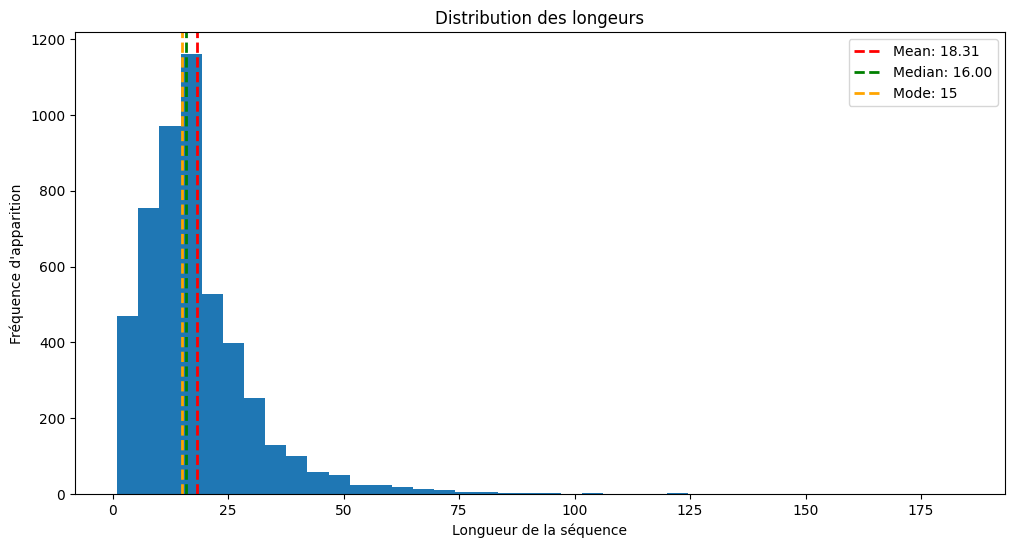

In [19]:

plt.figure(figsize=(12, 6))
plt.hist(
    x=df['text_size'],
    bins=40
)

sentences_sizes = df['text_size']
mean_val = sentences_sizes.mean()
median_val = sentences_sizes.median()
mode_val = sentences_sizes.mode()[0]

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(mode_val, color='orange', linestyle='--', linewidth=2, label=f'Mode: {mode_val}')

plt.legend()
plt.xlabel("Longueur de la séquence")
plt.ylabel("Fréquence d'apparition")
plt.title('Distribution des longeurs')
plt.show()

In [26]:
max_sentence_length=40

In [28]:
df = df[df['text_size'] <= max_sentence_length]

df_train_X: DataFrame
df_train_y: Series
df_test_X: DataFrame
df_test_y: Series

df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(
    df, df['toxic'],
    stratify=df['toxic'],
    random_state=SEED,
    test_size=0.2
)

In [29]:

display(Markdown(
f"""
Répartition des jeux de données
- Entrainement : {len(df_train_y):n} messages avec {df_train_y.sum():n} considérés toxique ({df_train_y.sum()/len(df_train_y):.2%})
- Test : {len(df_test_y)} messages avec {df_test_y.sum():n} considérés toxique ({df_test_y.sum()/len(df_test_y):.2%})
"""))


Répartition des jeux de données
- Entrainement : 3782 messages avec 1852 considérés toxique (48.97%)
- Test : 946 messages avec 463 considérés toxique (48.94%)


# LSTM

In [30]:
# Tokenizer
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
    # split = "whitespace",
    output_sequence_length=max_sentence_length,
)

tokenizer.adapt(df['text'])

In [31]:
# Séquences
X_train_seq = tokenizer(df_train_X['text'])
X_test_seq = tokenizer(df_test_X['text'])

print(X_train_seq[0])

tf.Tensor(
[   63  3932    46  1005     6     8    28  5951     3    99    33    11
 10737   864     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int64)


In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Input

lstm = models.Sequential([
    Input((1,), dtype=tf.string),
    tokenizer,

    layers.Embedding(tokenizer.vocabulary_size(), 32, input_length=64),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 40)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 40, 32)         │       379,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 40, 64)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,057 (1.62 MB)

 Trainable params: 425,057 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
lstm.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6909 - loss: 0.5653 - val_accuracy: 0.8362 - val_loss: 0.3852
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9418 - loss: 0.1676 - val_accuracy: 0.8985 - val_loss: 0.3027
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9818 - loss: 0.0592 - val_accuracy: 0.9027 - val_loss: 0.3216
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9952 - loss: 0.0215 - val_accuracy: 0.9133 - val_loss: 0.3292
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9944 - loss: 0.0221 - val_accuracy: 0.9017 - val_loss: 0.3733


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8985  |  Precision: 0.8815  |  Recall: 0.9158  |  F1: 0.8983



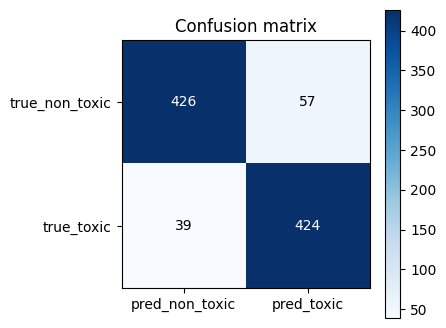

Classification report:

              precision    recall  f1-score   support

       False     0.9161    0.8820    0.8987       483
        True     0.8815    0.9158    0.8983       463

    accuracy                         0.8985       946
   macro avg     0.8988    0.8989    0.8985       946
weighted avg     0.8992    0.8985    0.8985       946



================================================================================  
10 exemples de MAUVAISE PRÉDICTION  
================================================================================  
Exemple 1:  
- Phrase: Donne m en une provision aussi... Saleté de piaf !
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 98.55% / probability: 0.0145)


Exemple 2:  
- Phrase: et répondu Tant mieux si tu as débusqué ta filleule et qu elle te plait bien
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 99.76% / probability: 0.9976)


Exemple 3:  
- Phrase: Aurons-nous droit à un scénario digne des Caves du Vatican ?
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 80.80% / probability: 0.8080)


Exemple 4:  
- Phrase: Jean-Paul Ney est une sous-merde, bien content que la justice commence à s'occuper de son cas.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 83.73% / probability: 0.1627)


Exemple 5:  
- Phrase: Toutes façons si on se prend 200 millions de personnes on va pas résister grand chose hein.
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 92.75% / probability: 0.9275)


Exemple 6:  
- Phrase: , tu finiras en enfer avec moi (avec pour sanction de corriger indéfiniment mes mauvaises redirections wikipédiennes... )
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 92.62% / probability: 0.0738)


Exemple 7:  
- Phrase: Je vois que tu t en es généreusement chargé, merci.
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 72.98% / probability: 0.7298)


Exemple 8:  
- Phrase: Apprends à toucher aux réglages parce que L'apn est mieux que celui de mon htc 10 et qui rivalise avec le s7 edge.
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 73.25% / probability: 0.7325)


Exemple 9:  
- Phrase: T as besoin d aller de pleindre aux  administrateurs  pour me mettre un avertissement sans savoir si je fais du vandalisme pur et simple trou d balle!???
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 95.44% / probability: 0.0456)


Exemple 10:  
- Phrase: T as besoin d aller de pleindre aux  administrateurs  pour me mettre un avertissement sans savoir si je fais du vandalisme pur et simple trou d balle!???
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 95.44% / probability: 0.0456)



In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


p = lstm.predict(tf.convert_to_tensor(np.array(df_test_X['text']), dtype=tf.string))
# convertir éventuellement p en vecteur de probabilités
probs: np.ndarray = p.flatten()
preds: list[bool] = (probs > 0.5).flatten().tolist()
reals: list[bool] = (df_test_y == 1).values.tolist()

# métriques globales
acc = accuracy_score(reals, preds)
prec = precision_score(reals, preds, zero_division=0)
rec = recall_score(reals, preds, zero_division=0)
f1 = f1_score(reals, preds, zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")

# matrice de confusion
cm = confusion_matrix(reals, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xticks([0,1], ["pred_non_toxic", "pred_toxic"])
plt.yticks([0,1], ["true_non_toxic", "true_toxic"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
plt.colorbar()
plt.show()

# rapport détaillé
print("Classification report:\n")
print(classification_report(reals, preds, digits=4, zero_division=0))



# Je veux 10 exemples de mauvaise prédiction et la phrases d'entrée
# Trouver les mauvaises prédictions
rand_i = np.random.random_integers(0, len(reals) - 1, len(reals))
wrong_predictions_indices = [int(i) for i in rand_i if reals[i] != preds[i]]

# Afficher les 10 premiers exemples de mauvaise prédiction

md_texts: list[str] = [
    "="*80 + "  ",
    "10 exemples de MAUVAISE PRÉDICTION  ",
    "="*80 + "  "
]

for count, idx in enumerate(wrong_predictions_indices[:10]):
    actual = "TOXIC" if reals[idx] else "NON-TOXIC"
    predicted = "TOXIC" if preds[idx] else "NON-TOXIC"
    prob = probs[idx]
    
    md_texts.append(f"Exemple {count + 1}:  ")
    md_texts.append(f"- Phrase: {df_test_X['text'].tolist()[idx]}")
    md_texts.append(f"- Réel: {actual}")
    md_texts.append(f"- Prédiction: {predicted} (confiance: {(prob if prob > 0.5 else 1 - prob):.2%} / probability: {prob:.4f})")
    md_texts.append(f"\n")

display(Markdown("\n".join(md_texts)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy: 0.6994  |  Precision: 0.8333  |  Recall: 0.6481  |  F1: 0.7292



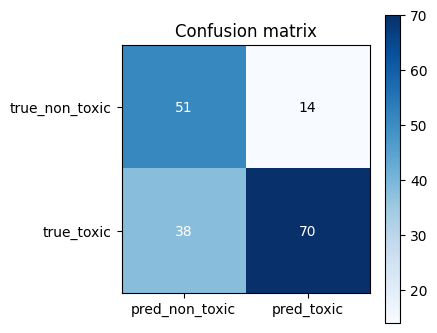

Classification report:

              precision    recall  f1-score   support

       False     0.5730    0.7846    0.6623        65
        True     0.8333    0.6481    0.7292       108

    accuracy                         0.6994       173
   macro avg     0.7032    0.7164    0.6958       173
weighted avg     0.7355    0.6994    0.7041       173



================================================================================  
10 exemples de MAUVAISE PRÉDICTION  
================================================================================  
Exemple 1:  
- Phrase: Cette personne est un idiot complet !
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 55.15% / probability: 0.4485)


Exemple 2:  
- Phrase: Je suis en colère contre ce qu'ils ont fait.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 98.81% / probability: 0.0119)


Exemple 3:  
- Phrase: Je te déteste depuis longtemps
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 67.31% / probability: 0.3269)


Exemple 4:  
- Phrase: J'ai été ruiné par cette décision.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 94.93% / probability: 0.0507)


Exemple 5:  
- Phrase: J'ai été blessé par ce qu'ils ont fait.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 98.22% / probability: 0.0178)


Exemple 6:  
- Phrase: Je suis heureux que vous ayez partagé cette information.
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 55.38% / probability: 0.5538)


Exemple 7:  
- Phrase: Ce produit est inutile, ne le achetez pas.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 92.79% / probability: 0.0721)


Exemple 8:  
- Phrase: Je suis en colère contre cette entreprise.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 90.74% / probability: 0.0926)


Exemple 9:  
- Phrase: Ce film est une catastrophe, évitez-le absolument.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 98.08% / probability: 0.0192)


Exemple 10:  
- Phrase: Cet article est un scandale, il faut le faire cesser.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 99.59% / probability: 0.0041)



In [52]:
import generated_ai_comments

toxic_comments: list[str] = generated_ai_comments.llama3_1_8b_local['toxic_comments']
toxicless_comments: list[str] = generated_ai_comments.llama3_1_8b_local['toxicless_comments']

sentences_validation: list[str] = [
    *toxic_comments,
    *toxicless_comments
]

p = lstm.predict(tf.convert_to_tensor(sentences_validation, dtype=tf.string))
# convertir éventuellement p en vecteur de probabilités
probs: np.ndarray = p.flatten()
preds: list[bool] = (probs > 0.5).flatten().tolist()
reals: list[bool] = [*[True] * len(toxic_comments), *[False] * len(toxicless_comments)]

# métriques globales
acc = accuracy_score(reals, preds)
prec = precision_score(reals, preds, zero_division=0)
rec = recall_score(reals, preds, zero_division=0)
f1 = f1_score(reals, preds, zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")

# matrice de confusion
cm = confusion_matrix(reals, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xticks([0,1], ["pred_non_toxic", "pred_toxic"])
plt.yticks([0,1], ["true_non_toxic", "true_toxic"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
plt.colorbar()
plt.show()

# rapport détaillé
print("Classification report:\n")
print(classification_report(reals, preds, digits=4, zero_division=0))

# Je veux 10 exemples de mauvaise prédiction et la phrases d'entrée
# Trouver les mauvaises prédictions
rand_i = np.random.random_integers(0, len(reals) - 1, len(reals))
wrong_predictions_indices = [i for i in rand_i if reals[i] != preds[i]]

# Afficher les 10 premiers exemples de mauvaise prédiction

md_texts: list[str] = [
    "="*80 + "  ",
    "10 exemples de MAUVAISE PRÉDICTION  ",
    "="*80 + "  "
]

for count, idx in enumerate(wrong_predictions_indices[:10]):
    actual = "TOXIC" if reals[idx] else "NON-TOXIC"
    predicted = "TOXIC" if preds[idx] else "NON-TOXIC"
    prob = probs[idx]
    
    md_texts.append(f"Exemple {count + 1}:  ")
    md_texts.append(f"- Phrase: {sentences_validation[idx]}")
    md_texts.append(f"- Réel: {actual}")
    md_texts.append(f"- Prédiction: {predicted} (confiance: {(prob if prob > 0.5 else 1 - prob):.2%} / probability: {prob:.4f})")
    md_texts.append(f"\n")

display(Markdown("\n".join(md_texts)))